# Wine Price Predictor<a name = 'beginning'></a>    


In this project I will apply EDA, missing value processing, data visualization and categorical data coding. The project is purely a learning project.    


The data was taken from the Kaggle database [kaggle.com](https://www.kaggle.com/)  

### Problem statement  

> to determine the price of wine   
    
### Goals of this project   

* Practice EDA: Data Loading, Data Familiarization, Data Cleaning;   
* Practice Outliers Excluding;  
* Practice Data Visualisation;
* Practice Categorical Variables Processing.    

### Steps   

* [Data Loading](#loading)   
* [Getting Familiar With the Data](#familiar)    
* [Missing Values Processing](#missing_values)      
* [Outliers Excluding](#outliers)    
* [Selecting Features for Model Training](#features_selection)    
* [Preparing Data for Training](#preparing)    
* [Coding the Categorical Variables](#coding_cv)   
* [Training the Model](#training)  

In [50]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

### Data Loading<a name = 'loading'></a>   

[The Beginning](#beginning)  

In [51]:
data_path = 'data/winemag-data-130k-v2.csv'

data = pd.read_csv(data_path, index_col = 0)

### Getting Familiar With the Data<a name = 'familiar'></a>   

[The Beginning](#beginning)  

In [52]:
print(data.shape, '\n')

print(data.dtypes)

data.head()

(129971, 13) 

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Let's collect the categorical and numerical columns into separate variables for convenience later on.

In [53]:
# Get cols with object type
object_cols = [col for col in data.columns if data[col].dtype == 'object']

# Get cols with numerical type
num_cols = [col for col in data.columns if data[col].dtype != 'object']

# Check that everything works correctly
print("Object cols: ", object_cols, '\n')
print('Numerical cols: ', num_cols)

Object cols:  ['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery'] 

Numerical cols:  ['points', 'price']


### Missing Values Processing<a name = 'missing_values'></a>  

[The Beginning](#beginning)  

I'll use an **Imputation with Most Frequent Value** approach for the categorical data   

In [54]:
# Let's check how many empty fields there are in each categorical column
for col in object_cols:
    nan_count = data[col].isnull().sum()
    print(col, ': ', nan_count, ' from ', len(data))

country :  63  from  129971
description :  0  from  129971
designation :  37465  from  129971
province :  63  from  129971
region_1 :  21247  from  129971
region_2 :  79460  from  129971
taster_name :  26244  from  129971
taster_twitter_handle :  31213  from  129971
title :  0  from  129971
variety :  1  from  129971
winery :  0  from  129971


In [55]:
# Create list with the most frequent values for categorical variables

most_frequent_values = []
for col in object_cols:
    most_frequent_values.append(data[col].mode()[0])

    
    
# Put the most frequent values into empty fields

for i in range(len(object_cols)):
    data.loc[data[object_cols[i]].isnull(), object_cols[i]] = most_frequent_values[i]

In [56]:
# Check that there are no empty fields left

for col in object_cols:
    nan_count = data[col].isnull().sum()
    print(col, ': ', nan_count, ' Nan from ', len(data))

country :  0  Nan from  129971
description :  0  Nan from  129971
designation :  0  Nan from  129971
province :  0  Nan from  129971
region_1 :  0  Nan from  129971
region_2 :  0  Nan from  129971
taster_name :  0  Nan from  129971
taster_twitter_handle :  0  Nan from  129971
title :  0  Nan from  129971
variety :  0  Nan from  129971
winery :  0  Nan from  129971


And I will use an **Imputation with Mean** approach for the numerical data

In [57]:
# Firstly, let's check how many empty fields there are now
for col in num_cols:
    nan_count = data[col].isnull().sum()
    print(col, ': ', nan_count, ' from ', len(data))


points :  0  from  129971
price :  8996  from  129971


In [58]:
data.loc[data['price'].isnull(), 'price'] = data['price'].mean()

In [59]:
# Check that in the data there are no missing values left
print(data.isnull().any())

country                  False
description              False
designation              False
points                   False
price                    False
province                 False
region_1                 False
region_2                 False
taster_name              False
taster_twitter_handle    False
title                    False
variety                  False
winery                   False
dtype: bool


### Outliers Excluding<a name='outliers'></a>   

[The Beginning](#beginning)  

<AxesSubplot:xlabel='points', ylabel='price'>

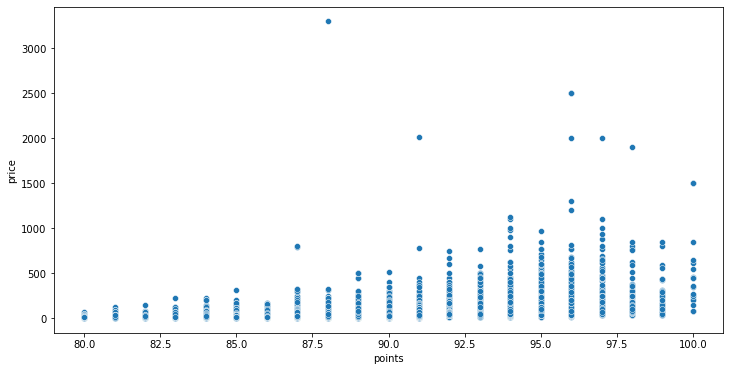

In [60]:
#Let's visualize the spread of wine prices to see wether there are outliers

plt.figure(figsize=(12,6))
sns.scatterplot(x = data['points'], y = data['price'])


Let's use IQR to find outliers and exclude them from the dataset.

In [61]:
# Calculate the Interquartile Range
quartile1, quartile3 = np.percentile(data.price, [25, 75])
iqr = quartile3 - quartile1

# Let's define the boundaries beyond which the value will be considered an outlier.
low_border = quartile1 - 1.5 * iqr
high_border = quartile3 + 1.5 * iqr

# Excluding the outliers
mask = (data.price >= low_border) & (data.price <= high_border)
data = data[mask]

Text(0.5, 1.0, 'Relationship between points and wine price')

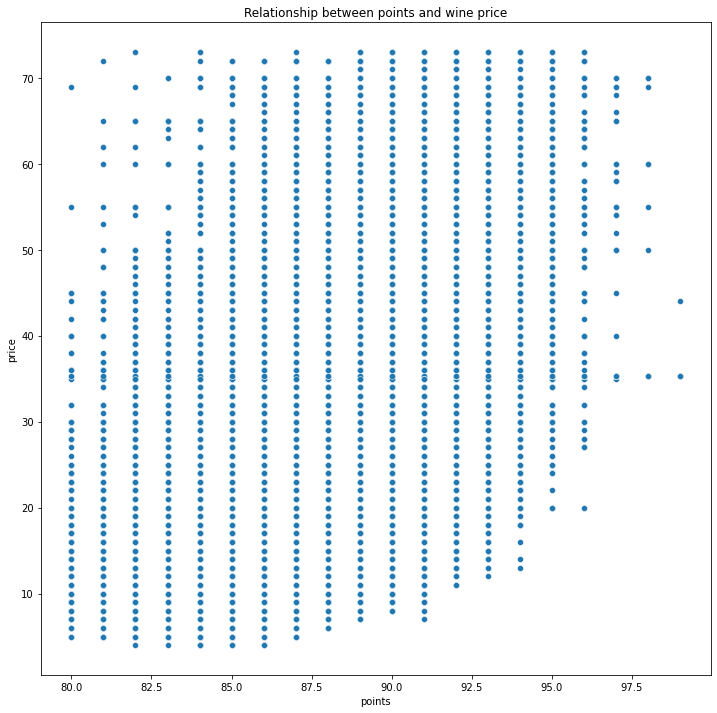

In [62]:
# Check that there are no outliers left
plt.figure(figsize=(12,12))
sns.scatterplot(x = data['points'], y = data['price'])
plt.title('Relationship between points and wine price')

### Selecting Features for Model Training<a name = 'features_selection'></a>               

[The Beginning](#beginning)   


Now I need to select the features that are best suited for training the model.

Logically, one can conclude that the `description`, `taster_name`, `taster_twitter_handle` columns don't contain information that affects the price of wine. Therefore, I won't use them to train the model.

The `designation`, `title`, and `winery` columns consist entirely or mostly of very small categories: 

In [63]:
print('Number of rows in the dataset: ', data.shape[0])

print('\nNumber of unique values in \'title\' column: ', data.title.nunique())

print('\nNumber of unique values in \'winery\' column: ', data.winery.nunique())

print('The largest category in \'winery\' column has ', data.winery.value_counts()[0], ' entries')

designation_counts = data['designation'].value_counts()
infrequent_designations = designation_counts[designation_counts < 100]
print('\nNumber of unique values in \'designation\' column: ', data.designation.nunique(), ', and ', 
                                      infrequent_designations.count(), ' of them have less than 100 entries')


Number of rows in the dataset:  120918

Number of unique values in 'title' column:  110386

Number of unique values in 'winery' column:  16422
The largest category in 'winery' column has  218  entries

Number of unique values in 'designation' column:  35129 , and  35102  of them have less than 100 entries


Therefore, these columns are also uninformative for model training.    

The `region_2` column consisted of more than 60% empty values before filling. So I also consider it as uninformative.    

So, let's visualize remaining features to see if they do affect the price of the wine.

0.516265521189967

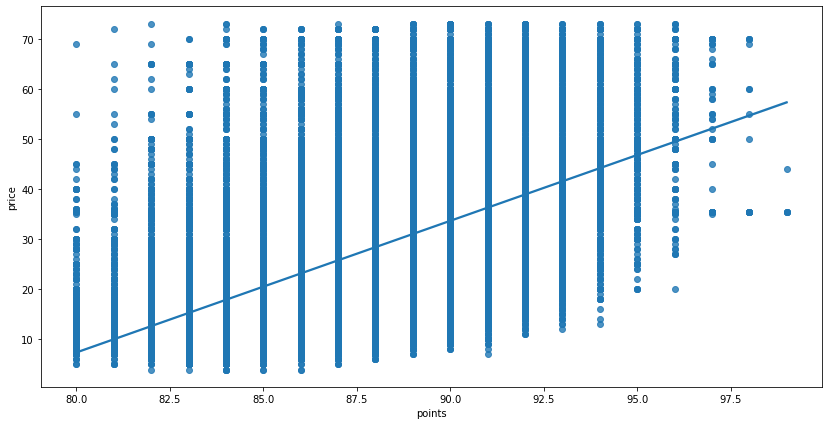

In [64]:
# Firstly I'll consider the only numerical column
plt.figure(figsize=(14,7))
sns.regplot(x=data.points, y=data.price)

np.corrcoef(data.points, data.price)[0, 1]

Both the graph and the value of the correlation coefficient suggest that `points` and `price` have a fairly strong positive correlation. So it's helpful to use this feature for model training.

Now it's time to consider categorical columns.   

I chose `pointplot` for this task rather than `violinplot` for example, because due to the number of categories in each column, I think pointplot is the easiest to understand visually.     

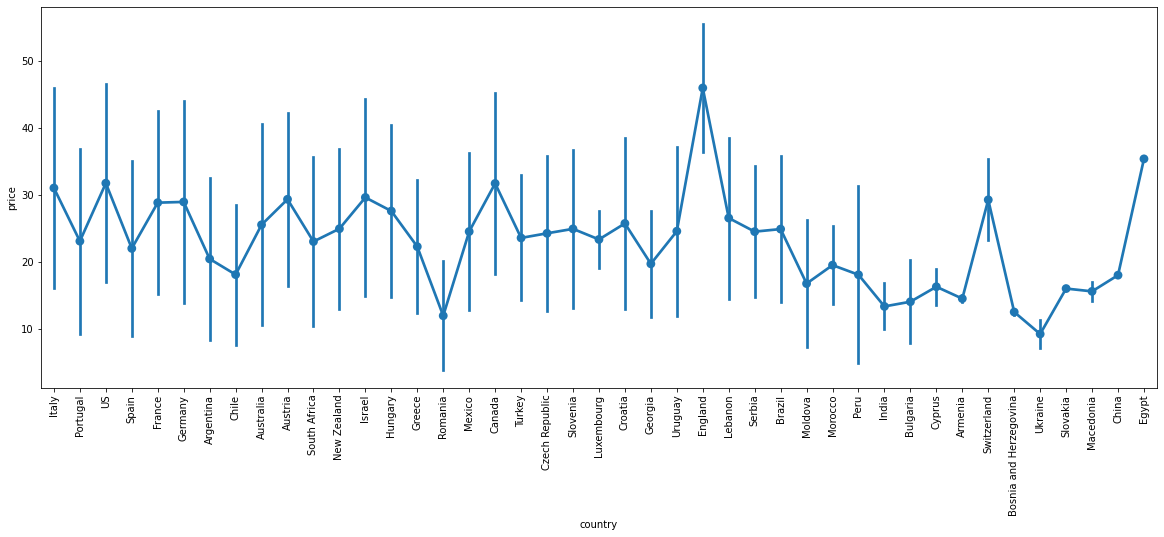

In [65]:
plt.figure(figsize=(20,7))
sns.pointplot(x='country', y='price', data=data, ci="sd")
plt.xticks(rotation=90)
plt.show()


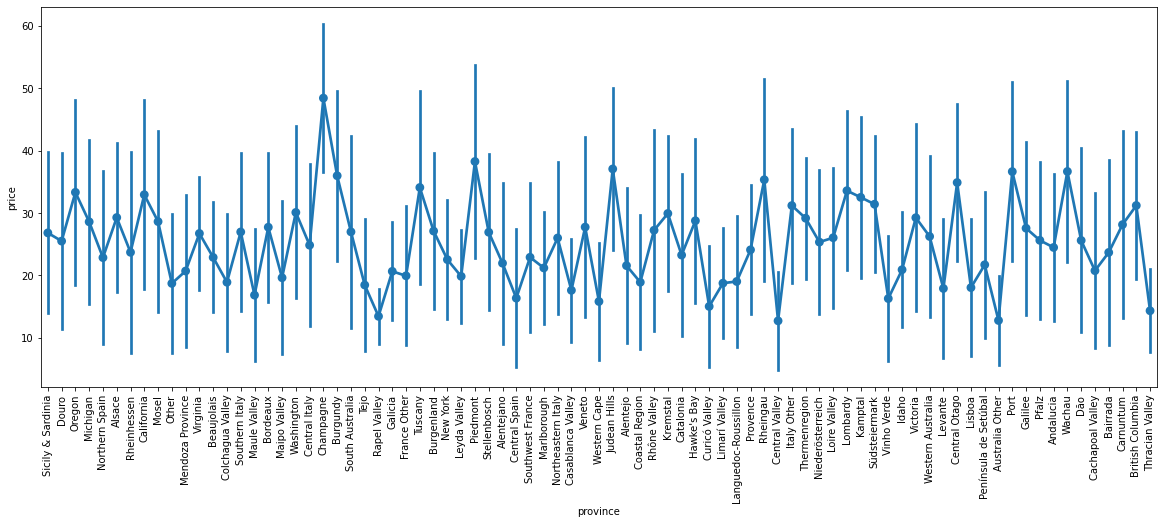

In [66]:
# For clarity, only categories with more than 100 entries will be considered. In a later step, small categories will 
# be collected as an "Other" category, so this step is not a dramatic simplification. The same approach will be applied for 
# 'region_1' and 'variety' columns.
province_counts = data.province.value_counts()

selected_provinces = province_counts[province_counts > 100].index

filtered_data = data[data.province.isin(selected_provinces)]

plt.figure(figsize=(20,7))
sns.pointplot(x='province', y='price', data=filtered_data, ci="sd")
plt.xticks(rotation=90)
plt.show()

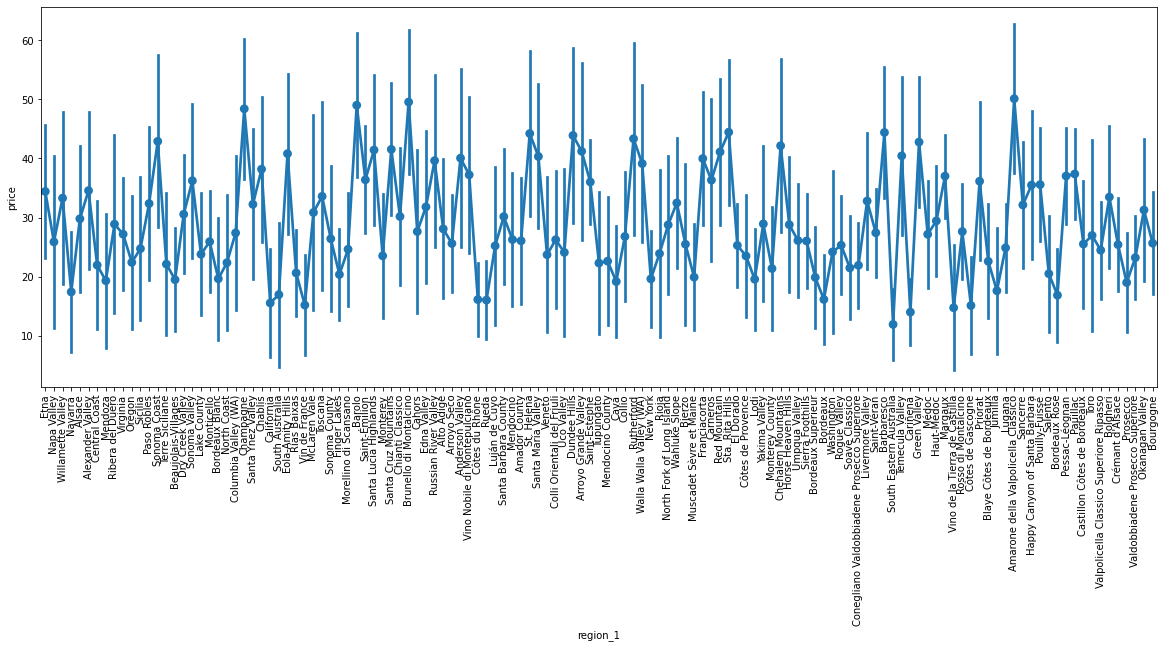

In [67]:
region_1_counts = data.region_1.value_counts()

selected_regions = region_1_counts[region_1_counts > 150].index

filtered_data = data[data.region_1.isin(selected_regions)]

plt.figure(figsize=(20,7))
sns.pointplot(x='region_1', y='price', data=filtered_data, ci="sd")
plt.xticks(rotation=90)
plt.show()

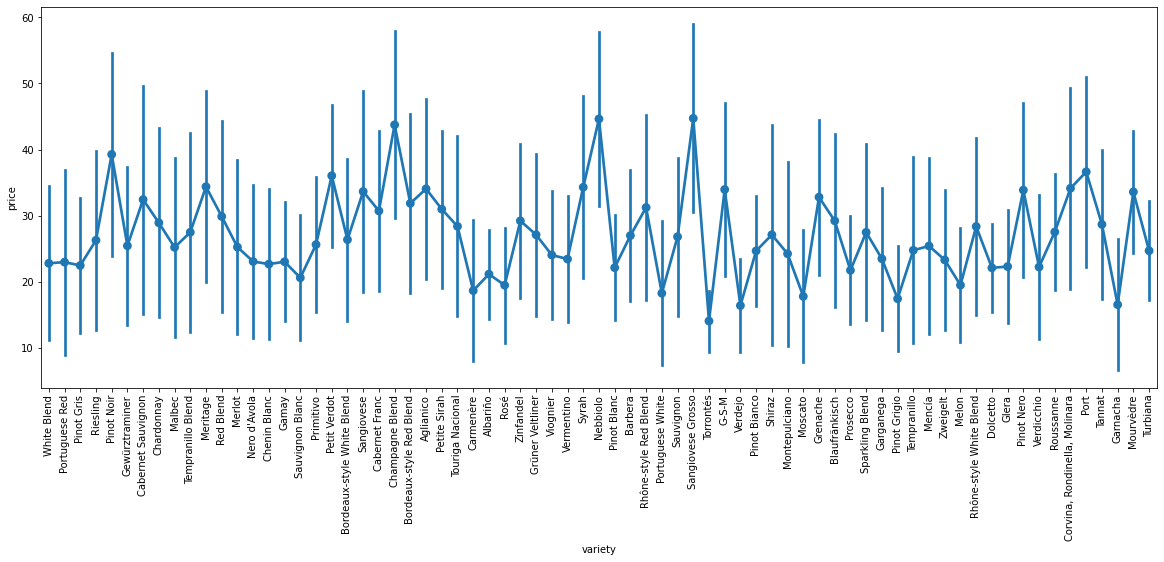

In [68]:
variety_counts = data.variety.value_counts()

selected_varieties = variety_counts[variety_counts > 150].index

filtered_data = data[data.variety.isin(selected_varieties)]

plt.figure(figsize=(20,7))
sns.pointplot(x='variety', y='price', data=filtered_data, ci="sd")
plt.xticks(rotation=90)
plt.show()

As can be seen in the graphs, all the columns considered have a correlation with the target value. Each category has a different mean value and a different spread pattern. Therefore, I conclude that the columns `country`, `province`, `region_1` and `variety` will be useful for model training.

### Preparing Data for Training<a name = 'preparing'></a>   

[The Beginning](#beginning)  

In [69]:
# Let's refresh our view of the data
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Central Coast,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,Napa Valley,Central Coast,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",Reserve,87,14.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Central Coast,Alexander Peartree,@vossroger,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Now we can set a target value and create DataFrame with features choosen for model training.

In [70]:
# Set the target value
y = data.price

# Create list of fetures that will be use in model training
wine_features = ['points', 'country', 'province', 'region_1', 'variety']

# Create a specific Frame for the list of the selected features
X = data[wine_features]

The `province`, `region_1` and `variety` columns contain many categories, some of wich are small and therefore unimformative. Let's combine those categories into the `Other` category. 

In [71]:
X.province.value_counts()

California     33327
Washington      8311
Bordeaux        5658
Tuscany         5088
Oregon          5071
               ...  
Dingač             1
Pocerina           1
Vlootenburg        1
Ticino             1
Neuchâtel          1
Name: province, Length: 424, dtype: int64

In [72]:
# Count the amount of entries of each value in the 'province column
province_counts = X.province.value_counts()

# Find values that appear less than 100 times
province_values_to_replace = province_counts[province_counts < 100].index

# Replace them with 'Other'
X.province = X.province.replace(province_values_to_replace, 'Other')

# Check the new number of categories
X.province.nunique()

C:\Users\samur\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


81

Now we have 81 categories in the `province` column instead of 424. Let's do the same thing for the `region_1` and `variety` columns.

In [73]:
X.region_1.value_counts()

Napa Valley                                          23954
Columbia Valley (WA)                                  4039
Russian River Valley                                  2980
California                                            2607
Paso Robles                                           2279
                                                     ...  
Gippsland                                                1
Colline Teramane                                         1
Vino de la Tierra Ribera del Gállego-Cinco Villas        1
Montlouis-sur-Loire                                      1
Paestum                                                  1
Name: region_1, Length: 1211, dtype: int64

In [74]:
region_1_counts = X.region_1.value_counts()

region_1_values_to_replace = region_1_counts[region_1_counts < 150].index

X.region_1 = X.region_1.replace(region_1_values_to_replace, 'Other')

X.region_1.nunique()

131

In [75]:
X.variety.value_counts()

Pinot Noir                  12023
Chardonnay                  11120
Red Blend                    8285
Cabernet Sauvignon           7623
Bordeaux-style Red Blend     6216
                            ...  
Chardonnay-Pinot Gris           1
Vitovska                        1
Sauvignonasse                   1
Gros Plant                      1
Bobal-Cabernet Sauvignon        1
Name: variety, Length: 703, dtype: int64

In [76]:
# Count the amount of entries of each value in the variety column
variety_counts = X.variety.value_counts()

# Find values that appear less than 100 times
variety_values_to_replace = variety_counts[variety_counts < 100].index

# Replace them with 'Other'
X.variety = X.variety.replace(variety_values_to_replace, 'Other')

# Print the result
X.variety.nunique()  

89

Now let's split the data into training and validation sets.

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Coding the Categorical Variables<a name = 'coding_cv'></a>   

[The Beginning](#beginning)  

In [78]:
# Select features that are object dtype
object_features = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Check that everything works correctly
print(object_features)

['country', 'province', 'region_1', 'variety']


In [79]:
# Transforming categorical data with OrdinalEncoder. I've choosen this one, because columns have a lot of categories 
# and One-Hot Encoder for example will increase the size of data very much

# All categories that were not in the training set but were encountered in the validation set will be coded as a 
# separate category with a 999 code
encoder_ignore = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value= 999)


for col in object_features:
    
    X_train.loc[:, col + '_encoded'] = encoder_ignore.fit_transform(X_train[[col]])
    X_val.loc[:, col + '_encoded'] = encoder_ignore.transform(X_val[[col]])

    

C:\Users\samur\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\samur\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\samur\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Now when we have encoded categorical columns, we can drop the original ones

In [80]:
X_train = X_train.drop(columns = ['country', 'variety', 'province', 'region_1'])
X_val = X_val.drop(columns = ['country', 'variety', 'province', 'region_1'])

### Training the Model<a name = 'training'></a>  

[The Beginning](#beginning)  

In [81]:
# Choosing the ML model
model = RandomForestRegressor(random_state=42)

# Training the model on training data
model.fit(X_train, y_train)

# Make a prediction for validation data
preds = model.predict(X_val)

# Get the value of MAE
mean_absolute_error(y_val, preds)

7.804841110172278